In [1]:
%run init_notebookspace.py

Current venv: C:\Users\LukasGrahl\Documents\GIT\memoire1\env_macro_rbc
DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm

az.style.use("arviz-darkgrid")
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

print(pm.__version__)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


4.4.0


In [3]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}


from config import plt_config
plt.rcParams.update(plt_config)

In [4]:
def simulate_ar(intercept, coef1, coef2, noise=1, *, warmup=10, steps=200):   
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup+steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup+steps):
        draws[step] = (
            intercept 
            + coef1 * draws[step-1]
            + coef2 * draws[step-2]
            + rng.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]

In [164]:
# AR1

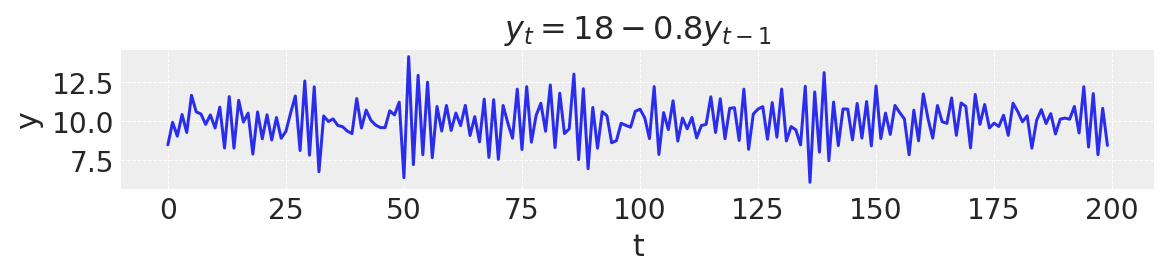

In [165]:
ar1_data = simulate_ar(18, -0.8, 0)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar1_data)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("$y_t = 18 - 0.8y_{t-1}$");

In [166]:
priors = {
    'coefs': {'mu': [10, .2], 'sigma': [.1, .1], 'size': 2},
    'sigma': 8,
    'init': {'mu': 9, 'sigma': .1, 'size': 1}
}

with pm.Model() as AR:
    pass

t_data = list(range(len(ar1_data)))
AR.add_coord('obs_id', t_data, mutable=True)

with AR:
    t = pm.MutableData('t', t_data, dims='obs_id')
    y = pm.MutableData('y', ar1_data, dims='obs_id')
    
    coefs = pm.Normal('coefs', priors['coefs']['mu'], priors['coefs']['sigma'])
    sigma = pm.Normal('simga', priors['sigma'])
    
    init = pm.Normal.dist(
        priors['init']['mu'], priors['init']['sigma'], size=priors['init']['size']
    )
    
    ar1 = pm.AR('ar1', coefs, sigma=sigma, constant=True,
                steps=t.shape[0] - (priors['coefs']['size'] - 1),
                dims='obs_id')
    
    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

C:\Users\LukasGrahl\miniconda3\envs\env_conda2_memoire1\Lib\site-packages\pymc\distributions\timeseries.py:566: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [ar1, coefs, likelihood, simga]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, simga, ar1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 85 seconds.
Sampling: [likelihood]


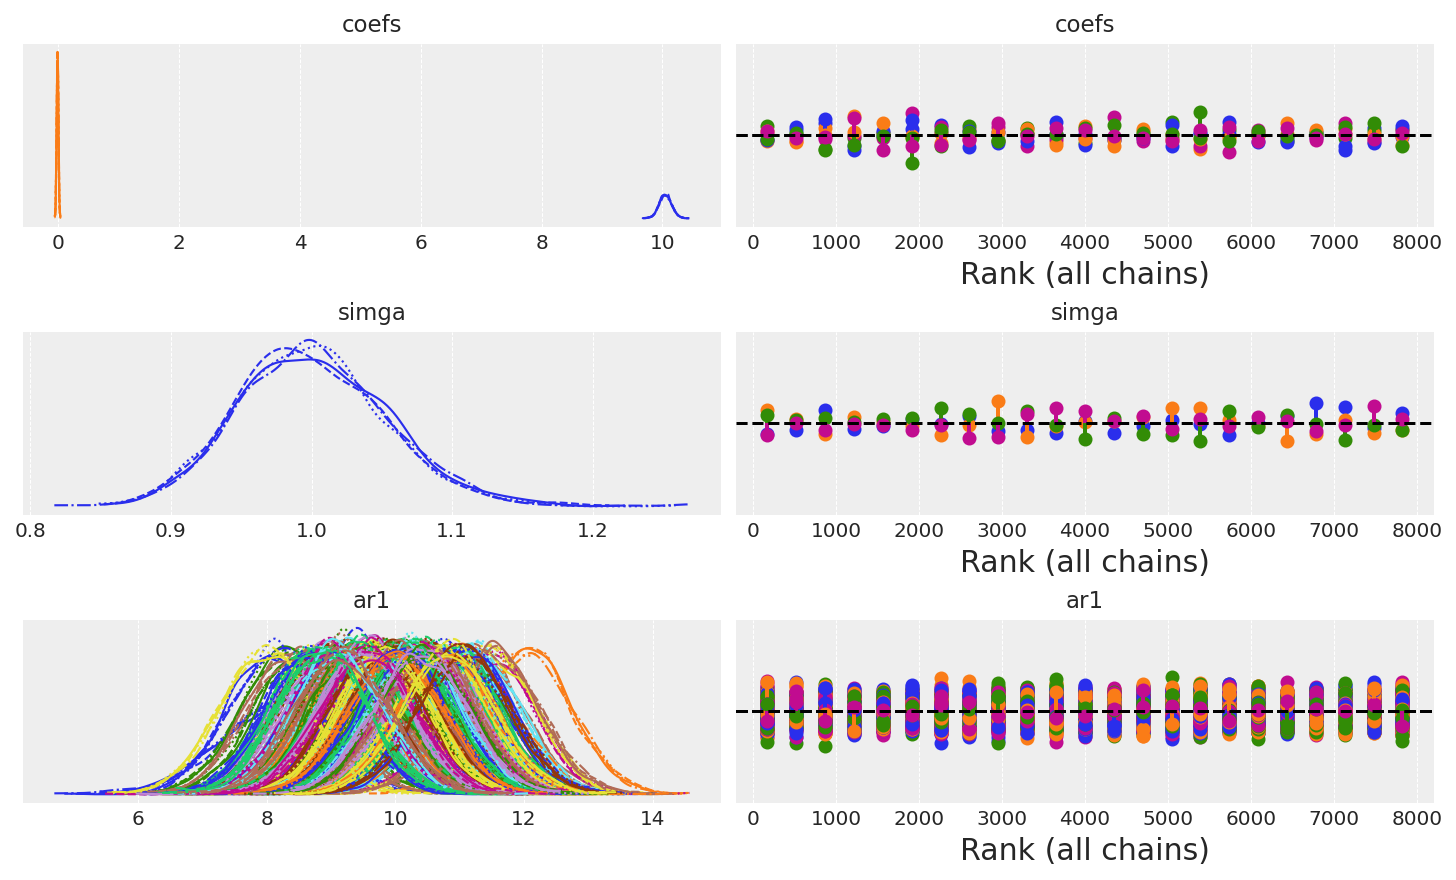

In [167]:
az.plot_trace(idata_ar, figsize=(10, 6), kind="rank_vlines");

In [168]:
# AR2

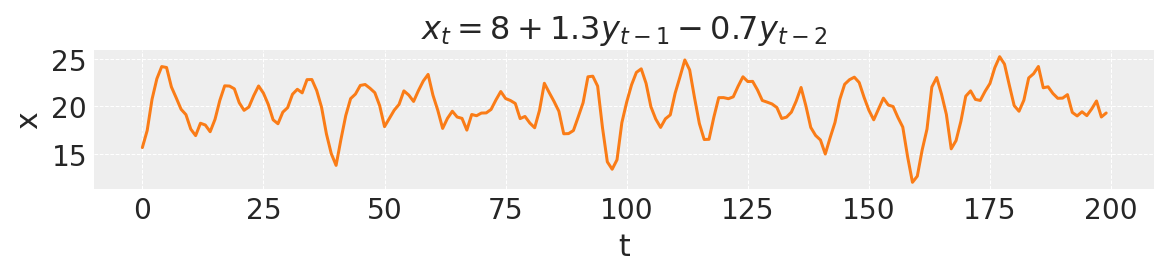

In [177]:
ar2 = simulate_ar(8, 1.3, -0.7)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar2, color="C1")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("$x_t = 8 + 1.3y_{t-1} - 0.7y_{t-2}$");

## BVAR

In [5]:
from src.process_data import load_data
from config import fred_dict
df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'is_test', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

df = df.drop(['pi', 'r', 'L', 'I'], axis=1).iloc[-100:].copy()
print(tuple(df.columns))

forecast_len = 5

data = df[:-forecast_len].copy()
test_data = df[-forecast_len:].copy()
data.shape, test_data.shape


Error occured 'is_test', file_dict may be incomplete
('Y', 'C')


((95, 2), (5, 2))

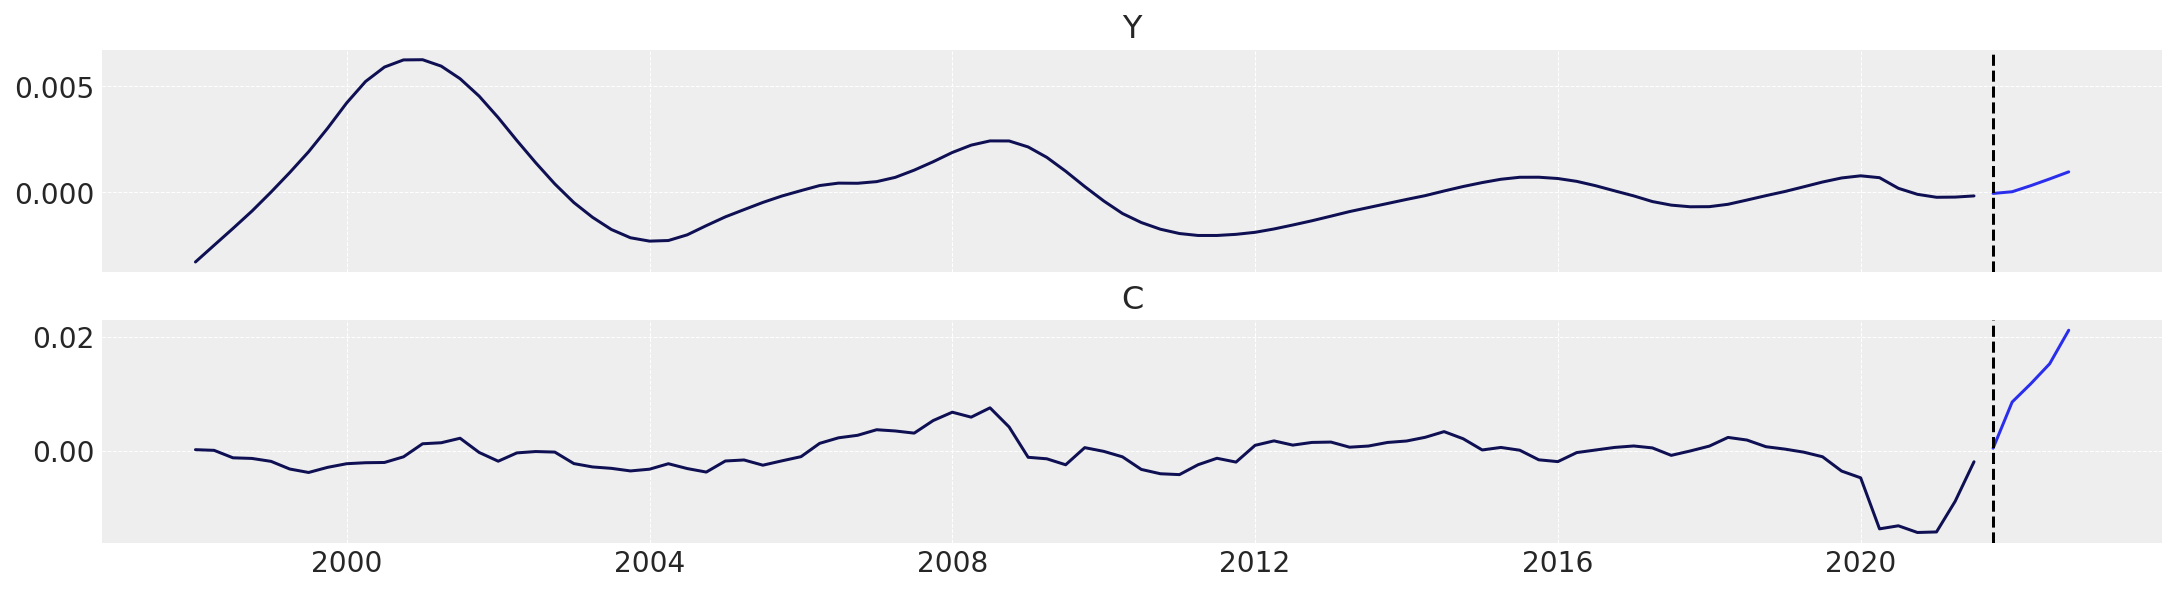

In [6]:
_, ax = plt.subplots(data.shape[1], 1, figsize=(15, 2 * df.shape[1]), sharex=True)

for i in range(0, data.shape[1]):
    ax[i].plot(data.iloc[:, i], color=dark["C0"], label="train")
    ax[i].plot(test_data.iloc[:, i], color="C0", label="test")
    ax[i].set_title(data.columns[i])
    
    ax[i].axvline(df.index[-forecast_len], ls='--', color='k')


In [7]:
# get p from statsmodels BIC

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

def grid_serach_var(data: pd.DataFrame, p_max: int = 15, ic: str = 'aic'):
    
    ic_res = []
    for p in range(1, p_max+1):
        mod = VAR(data)
        res = mod.fit(p)
        res.summary()
        
        if ic=='aic':
            ic_res.append(res.aic)
        elif ic=='bic':
            ic_res.append(res.bic)
    return ic_res

In [9]:
mod = VAR(data)
res = mod.fit(maxlags=15, ic='aic')

In [10]:
ics = np.array(grid_serach_var(data, p_max=19))

print(f'Lowest AIC at {np.where(1==(ics / np.min(ics)))[0] + 1} lags')

Lowest AIC at [9] lags


In [11]:
lags = 1

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": tuple(df.columns),
    "cross_vars": tuple(df.columns),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_list = []
    for ind in range(0, len(coords['cross_vars'])):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[i, ind] * data.values[lags-(i+1): -(i+1)], axis=-1) for i in range(lags)
            ]
            , axis=0
        )        
        ar_list.append(ar)
        
    mean = intercept + pm.math.stack(ar_list, axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

In [12]:
with BVAR_model:
    trace = pm.sample(chains=1, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, lag_coefs, noise]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 25 seconds.
c:\users\lukasgrahl\documents\git\macro_rbc\env_macro_rbc\lib\site-packages\arviz\data\base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


IndexError: arrays used as indices must be of integer (or boolean) type

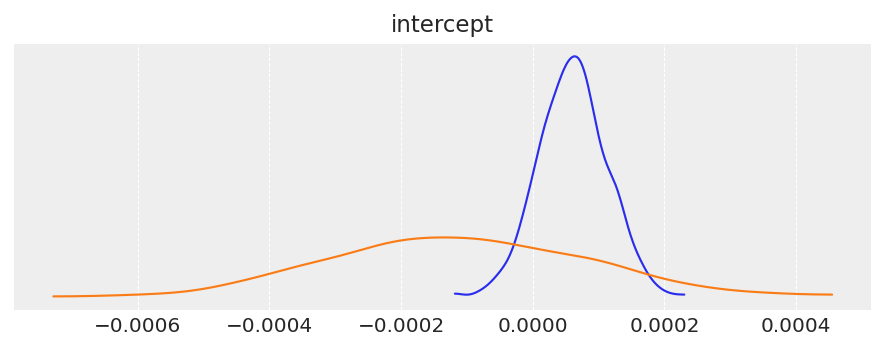

In [14]:
az.plot_trace(trace);

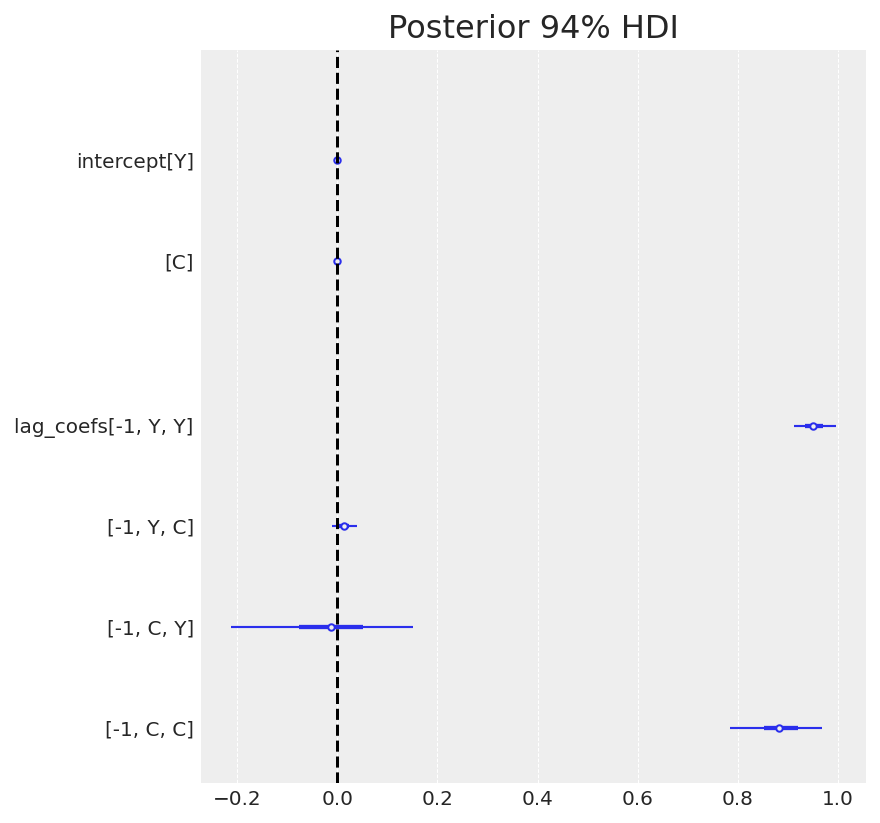

In [15]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [21]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=10):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_list = []
        for ind in range(0, len(coords['cross_vars'])):
            ar = np.sum(lag_coefs[:, ind] * new_draws[len_data+i-lags: len_data+i])
            ar_list.append(ar)
        mean = intercept + np.stack(ar_list)
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [25]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(1000, size=500)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((500, 2), (500, 1, 2, 2), (500, 2))

In [26]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=forecast_len)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

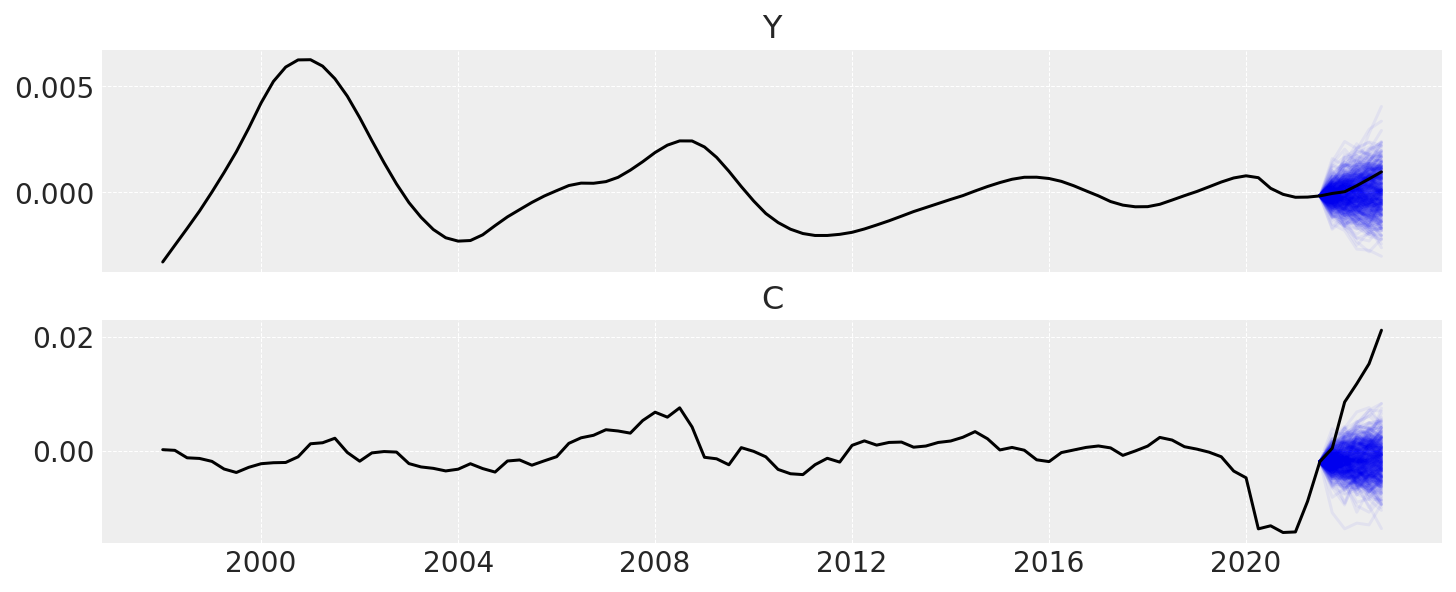

In [27]:
_, ax = plt.subplots(data.shape[1], 1, figsize=(10, 2 * df.shape[1]), sharex=True)

for i in range(0, data.shape[1]):
    ax[i].plot(df.index, ppc_draws[..., i], color="blue", alpha=.05)
    ax[i].plot(df.iloc[:, i], color="k", label="observed")
    ax[i].set_title(df.columns[i])
    ax[0].plot([], color="C0", label="forecast")

In [28]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data